# STAT5243 Project 4: Causal Inference

***Group 2:***

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2021)

# train-test split for propensity score
from sklearn.model_selection import train_test_split

# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# grid search
from sklearn.model_selection import GridSearchCV

# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Imbalance techniques
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

## Introduction

In [2]:
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')

The goal of this project is estimating the ATE of two dataset: high and low dimensional. 

In [3]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

## Import and explore data

To increase the usability of the notebook, we use generic variable names instead of associating with the datasets used in for the project. To use the notebook with other datasets, simply import with variable name `dataset`

In [69]:
dataset = highDim_dataset.copy()

# To use the low dim, import it instead 
# dataset = pd.read_csv('../data/lowDim_dataset.csv')

In [5]:
print(dataset.shape)
dataset.head()

(2000, 187)


,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


It is convenient to extract only the X portion, which is columns other than Y (treatment result) and A (treatment/control)

In [78]:
data_X = dataset.drop(['Y', 'A'], axis=1).copy()

In [79]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,0,1,4,18,17,-1,1,0.75,1,28,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,0,0,1,10,6,-1,10,0.35,1,30,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,0,0,16,8,4,4,4,0.40,1,26,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,0,3,10,2,-1,5,0.41,0,24,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,1,11,21,10,10,20,0.43,1,28,...,6,8,7,7,7,6,7,6,6,7


In [100]:
def plotComposition(dataset, reset_index=False):
    plt.plot(dataset[dataset.A == 1].Y.reset_index(drop=True) if reset_index else dataset[dataset.A == 1].Y, 'o', label='Treatment')
    plt.plot(dataset[dataset.A == 0].Y.reset_index(drop=True) if reset_index else dataset[dataset.A == 0].Y, 'ro', label='Control')
    plt.title("Data Distribution")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

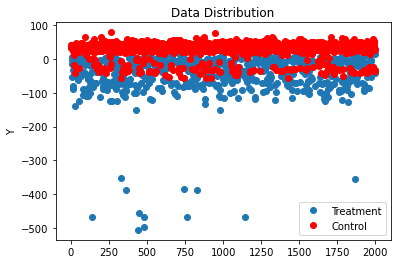

In [101]:
plotComposition(dataset)

**Naive estimate of ATE**

In [8]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [9]:
naive_ATE(dataset)

-75.17133436876799

## Are the data sets balanced?

In [10]:
def checkComposition(dataset):
    print("The dataset contains:\nTreatment:", 
          len(dataset[dataset.A == 1]), "cases"
          "\nControl:", 
          len(dataset[dataset.A == 0]), "cases")

In [11]:
checkComposition(dataset)

The dataset contains:
Treatment: 643 cases
Control: 1357 cases


Thus in this case, the data is slightly imbalanced, but acceptable. In any cases, one can use oversampling or smote to balance the data. Note that this may not be beneficial for some ATE estimation algorithm. 

In [12]:
def Oversample(dataset):
    ovs = RandomOverSampler(random_state = RANDOM_STATE)
    x,y = ovs.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    dataset_oversampled, dataset_oversampled["A"] = x, y
    return dataset_oversampled

The dataset contains:
Treatment: 1357 cases
Control: 1357 cases


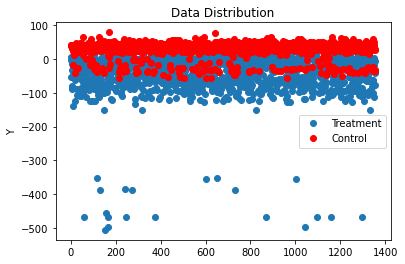

In [102]:
dataset_oversampled = Oversample(dataset)

checkComposition(dataset_oversampled)
plotComposition(dataset_oversampled, reset_index=True)

In [61]:
dataset_oversampled.head()

,Y,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V177,V178,V179,V180,V181,V182,V183,V184,V185,A
0,41.224513,0,1,4,18,17,-1,1,0.75,1,...,10,8,9,8,-1,-1,-1,-1,-1,0
1,40.513875,0,0,1,10,6,-1,10,0.35,1,...,5,6,8,5,-1,-1,-1,-1,-1,0
2,38.495476,0,0,16,8,4,4,4,0.40,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
3,33.001889,1,0,3,10,2,-1,5,0.41,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
4,37.043603,1,1,11,21,10,10,20,0.43,1,...,8,7,7,7,6,7,6,6,7,0


In [14]:
def SMOTE(dataset):
    smk = SMOTETomek()
    x, y = smk.fit_resample(dataset.loc[:,dataset.columns != 'A'], dataset.A)
    dataset_smote, dataset_smote["A"] = x, y
    return dataset_smote

The dataset contains:
Treatment: 1332 cases
Control: 1332 cases


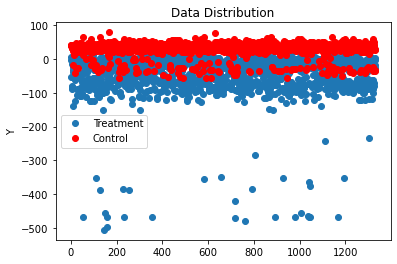

In [103]:
dataset_smote = SMOTE(dataset)

checkComposition(dataset_smote)
plotComposition(dataset_smote, reset_index=True)

## Split into train and test set

In [16]:
def split_train_test(dataset, test_size=0.2):
    X = np.array(dataset.drop(['Y', 'A'], axis=1))
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

In [17]:
X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(dataset)

## Propensity Score - Boosted Stumps

### Gradient Boosting

In [18]:
param_grid = {
              'learning_rate': [0.1,0.05,0.01],
              'max_depth': [2,3,5],
              'min_samples_split': [2, 4],
              'n_estimators': [100,150],
              'min_samples_leaf':[1,3,5]
              }

In [19]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        		print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

In [20]:
# grid_search(X_train, A_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE), print_step=False)

A copy of best hyperparameters from grid search

In [21]:
best_params = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}

In [22]:
gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params).fit(X_train, A_train)

In [23]:
print(gbm.score(X_train, A_train))
print(gbm.score(X_test, A_test))

0.885625
0.6875


In [35]:
propensity_score_gbm = np.exp(gbm.predict_log_proba(dataset.iloc[:, 2:]))[:, 1]

### Weighted XGBoost

In [24]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[10, 50, 100],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]
    #'scale_pos_weight':[1, 2, 4]
}

In [25]:
# grid_search(X_train, A_train, param_grid = param_grid_xgb, print_step=False, cv=5,
#                        model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE))

A copy of best hyperparameters from grid search

In [28]:
best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 
                        'objective': 'reg:squarederror', 'subsample': 0.8}

xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)

In [29]:
print(xgb.score(X_train, A_train))
print(xgb.score(X_test, A_test))

0.76625
0.6725


In [41]:
propensity_score_xgb = xgb.predict(np.array(dataset.iloc[:, 2:]))

## Calculating ATE

### Extract relevant data for ATE calculation

In [33]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data_combined = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data_combined

In [45]:
data_for_ATE = combine_data(propensity_score_gbm, dataset.A, dataset.Y)

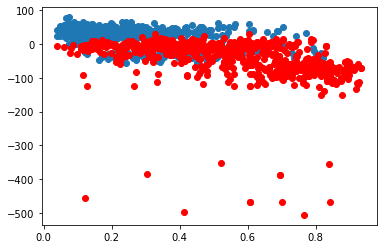

In [46]:
plt.plot(data_for_ATE[data_for_ATE.A==0].e, 
         data_for_ATE[data_for_ATE.A==0].Y, 'o')
plt.plot(data_for_ATE[data_for_ATE.A==1].e, 
         data_for_ATE[data_for_ATE.A==1].Y, 'ro')
plt.show()

### ATE Estimate - Stratification

In [47]:
def Stratify(data:pd.DataFrame, k:int):
    
    data_copy = data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [48]:
Stratify(data_for_ATE, 5)

,e,A,Y,bin
0,0.088950,0.0,41.224513,0
1,0.246304,0.0,40.513875,2
2,0.238758,0.0,38.495476,2
3,0.393209,0.0,33.001889,3
4,0.134864,0.0,37.043603,1
...,...,...,...,...
1995,0.330689,0.0,-34.599047,3
1996,0.577187,1.0,14.924050,4
1997,0.778520,1.0,-42.536491,4
1998,0.513597,0.0,-31.173675,3


In [55]:
def Calculate_ATE_Strat(data:pd.DataFrame, k:int):
    
    n = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        ATE += (nj/n) * ( np.average(Qj[Qj.A==1].Y) - np.average(Qj[Qj.A==0].Y) )
    
    return ATE

In [56]:
Calculate_ATE_Strat(data_for_ATE, 5)

-55.09861998297216

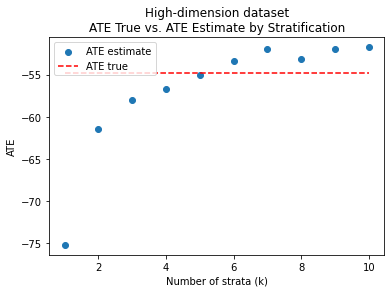

In [104]:
plt.scatter(range(1,11), [Calculate_ATE_Strat(data_for_ATE, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(high_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("High-dimensional dataset\nTrue ATE vs. Estimated ATE by Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

### ATE Estimate - Regression and Stratification with Regression Adjustment

In [98]:
def Calculate_ATE_StratRegrAdjusted_with_X(data:pd.DataFrame, X_data, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
        
    return ATE / k

In [99]:
Calculate_ATE_StratRegrAdjusted_with_X(data_for_ATE, data_X, 1)

-59.36544369185521

In [88]:
Calculate_ATE_StratRegrAdjusted_with_X(data_for_ATE, data_X, 5)

-55.92756544412039

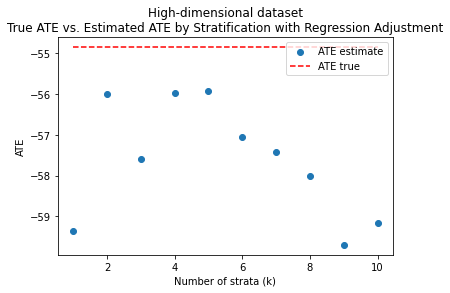

In [108]:
plt.scatter(range(1,11), [Calculate_ATE_StratRegrAdjusted_with_X(data_for_ATE, data_X, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(high_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("High-dimensional dataset\nTrue ATE vs. Estimated ATE by Stratification with Regression Adjustment")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

## Result Summary